## Time to get your hands dirty! - A nasty integral

Using Monte Carlo integration, check that

$$ \int_0^\infty x^3 \exp\left(-\frac{x^2}{2\sigma^2}\right) \,dx = 2\sigma^4 .$$

- Does the result converge with the number of samples? And how does the error go down?
- Do it many times. For a given $N$, how are the result distributed? We'll talk about model fitting at lenght later on, but for now try to fit it by hand with a parametrized model. (If N is large enough you should get something that looks *very* accurate! And if $N$ is small?)
- How does the distribution change if $N$ increases?

(Hint: think about sample mean and sample variance)


---




# Monte Carlo integration

## Theoretical aspects

The Monte Carlo integration method is based on the idea that an integral can be approximated by computing the mean value of the function evaluated at $N$ randomly sampled points, uniformly distributed over the integration domain.

$$
\int_a^b\,dx\, f(x) = \frac{b - a}{N}\sum_{i=1}^Nf(x_i)
$$

## Sampling generation

If we want to use the classical version of the MonteCarlo integration in order to calculate the integral: 

$$
\int_0^\infty \, dx\, x^3 e^{-\frac{x^2}{2\sigma^2}} = 2 \sigma^4
$$

We have to find a way to reduce the domain integration from $(0, \infty)$ to a finite one. 

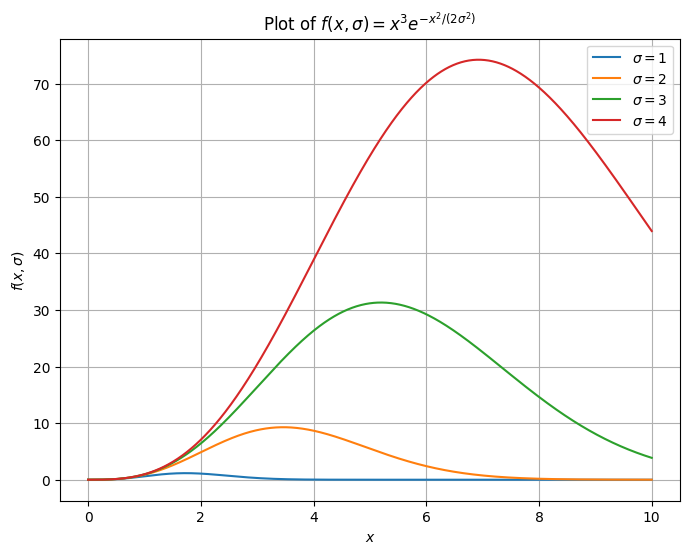

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f(x, sigma):
    return x**3 * np.exp(-x**2 / (2 * sigma**2))

x = np.linspace(0, 10, 1000)  
sigmas = [1, 2, 3, 4]

plt.figure(figsize=(8, 6))
for sigma in sigmas:
    plt.plot(x, f(x, sigma), label=rf"$\sigma = {sigma}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x, \sigma)$")
plt.title(r"Plot of $f(x, \sigma) = x^3 e^{-x^2 / (2\sigma^2)}$")
plt.legend()
plt.grid()
plt.show()

We observe that the function asymptotically approaches 0 for large $x$. To optimize the integration, we can set a threshold (e.g. $10^{-4}$) and consider that when the function goes under this limit, the contribution to the integral becomes negligible. 
In this way we can define a finite domain to aply the Monte Carlo algorithm. 

To find the zero we use the Newton-Raphson algorithm.

In [2]:
from scipy.optimize import newton
import random

# Compute derivative of f(x, sigma)
def df_dx(x, sigma):
    return (3*x**2 - x**4 / sigma**2) * np.exp(-x**2 / (2 * sigma**2))

# Function to find x where |f(x, sigma)| < threshold using Newton-Raphson
def find_threshold_x(sigma, x0=1.0, threshold=1e-4):
    def target_function(x):
        return f(x, sigma) - threshold

    try:
        x_threshold = newton(target_function, x0, fprime=lambda x: df_dx(x, sigma))
        # the lambda function is used to pass the derivative to the newton method as a function of x only
        return x_threshold
    except RuntimeError:
        return None  # If Newton's method fails to converge

def MonteCarlo_integration(function, min, max, N=10000): 
    x_samples = np.random.uniform(min, max, N)  # Generate random x values
    y_samples = function(x_samples)  # Evaluate function at sampled points

    return np.mean(y_samples) * (max - min)

sigmas = []
extremes = []
x0 = 1
for sigma in range(1, 100, 1): 
    max = find_threshold_x(sigma, x0)
    while max == None or  max < 1:
        x0 += 1
        max = find_threshold_x(sigma, x0)
    # the while loop ensures that max is found and is greater than 1, 
    # then the initial guess for the Newton-Raphson method is increased for the next iteration
    sigmas.append(sigma)
    extremes.append(max)

/tmp/ipykernel_26719/3404562399.py:5: RuntimeWarning: overflow encountered in scalar power
  return x**3 * np.exp(-x**2 / (2 * sigma**2))
/tmp/ipykernel_26719/3404562399.py:5: RuntimeWarning: invalid value encountered in scalar multiply
  return x**3 * np.exp(-x**2 / (2 * sigma**2))
/tmp/ipykernel_26719/3919024060.py:6: RuntimeWarning: overflow encountered in scalar power
  return (3*x**2 - x**4 / sigma**2) * np.exp(-x**2 / (2 * sigma**2))
/tmp/ipykernel_26719/3919024060.py:6: RuntimeWarning: invalid value encountered in scalar subtract
  return (3*x**2 - x**4 / sigma**2) * np.exp(-x**2 / (2 * sigma**2))
/tmp/ipykernel_26719/3919024060.py:6: RuntimeWarning: invalid value encountered in scalar multiply
  return (3*x**2 - x**4 / sigma**2) * np.exp(-x**2 / (2 * sigma**2))


The **Newton-Raphson** method is an iterative numerical technique used to find approximate solutions to equations of the form $f(x) = 0$. The method starts with an initial guess $x_0$ and iteratively refines this guess using the formula:
$$
x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}
$$  
where $f'(x_n)$ is the derivative of the function evaluated at $x_n$. The process is repeated until a sufficiently accurate approximation of the root is found, typically when the change between successive iterations is smaller than a predefined tolerance level.

### Plot the results

#### Residue vs sigma

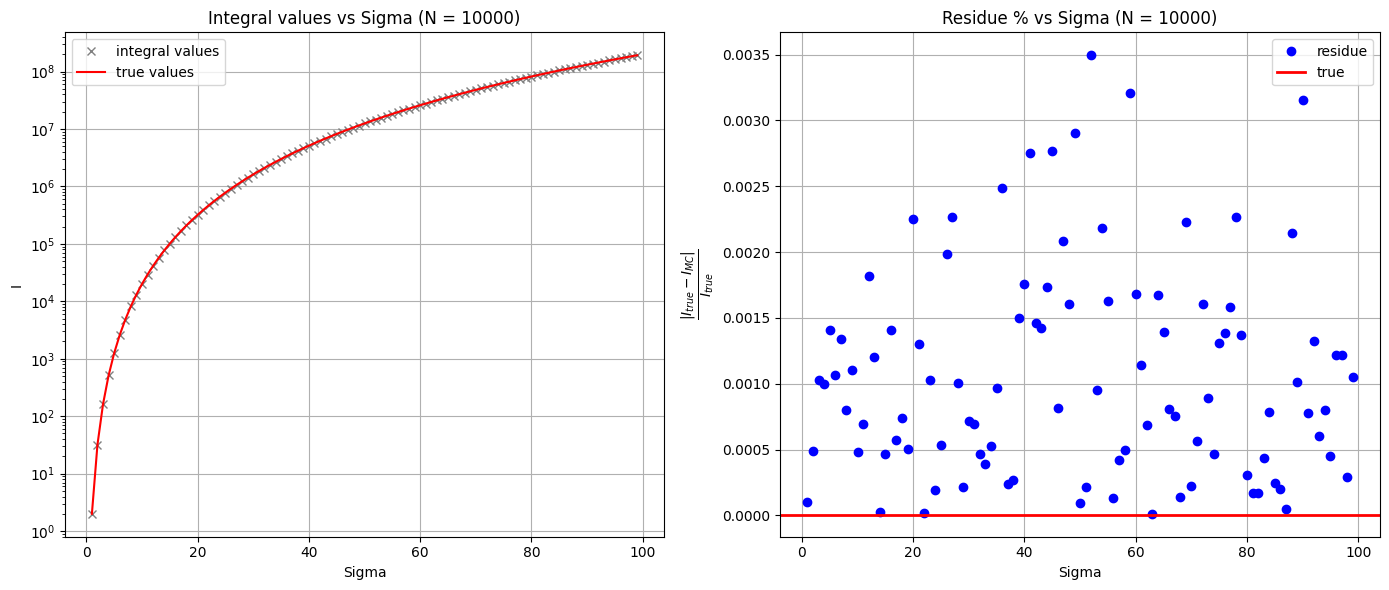

In [3]:
l = 100 # number of time we repeat the experiment to metegate the statistical noise

integral_values = []
true_values = []
residue = []
for sigma, max in zip(sigmas, extremes):
    f_lambda = lambda x: f(x, sigma)
    integral_value = 0
    for _ in range(l):
        integral_value += MonteCarlo_integration(f_lambda, 0, max)
    integral_value /= l

    true_value = 2 * sigma ** 4
    integral_values.append(integral_value)
    true_values.append(true_value)
    residue.append(np.abs(true_value - integral_value)/true_value)

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(sigmas, integral_values, "x", label="integral values", color="gray")
axs[0].plot(sigmas, true_values, label="true values", color="red")
axs[0].set_xlabel("Sigma")
axs[0].set_ylabel("I")
axs[0].set_title("Integral values vs Sigma (N = 10000)")
axs[0].set_yscale("log")
axs[0].legend()
axs[0].grid()

axs[1].plot(sigmas, residue, "o", label="residue", color="blue")
axs[1].axhline(0, color='red', linewidth=2, label='true')
axs[1].set_xlabel("Sigma")
axs[1].set_ylabel(r"$\frac{|I_{true} - I_{MC}|}{I_{true}}$", size=14)
axs[1].set_title("Residue % vs Sigma (N = 10000)")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

We use the residue divided by the true value of the integral instead of the classical residue because the integral value changes with sigma, so the residue would not be comparable for different values of sigma.

#### Fit to verify how the algorithm scales
$$
\sigma \propto \frac{1}{\sqrt{N}}
$$
To verify this relation we can plot $\log(|I_{true} - I_{MC}|)$ vs $\log(\frac{1}{N})$.
$$
|I_{true} - I_{MC}|\propto\frac{1}{\sqrt{N}}
$$
$$
\log(|I_{true} - I_{MC}|)\propto\frac{1}{2}\log\bigg(\frac{1}{N}\bigg)
$$
So if we fit the data with a model like: 
$$
y = \alpha x + \beta
$$
and we find $\alpha = \frac{1}{2}$, we have solved the problem.

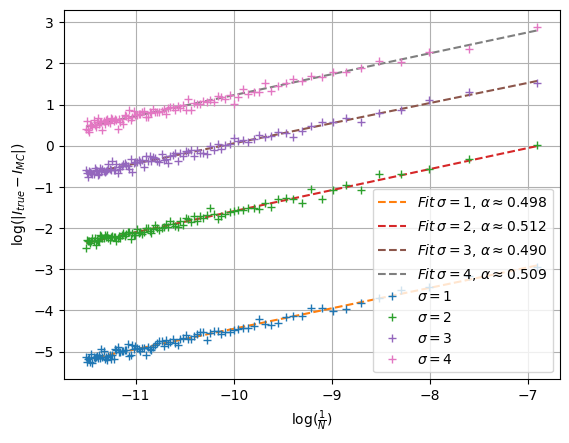

In [4]:
from scipy.optimize import curve_fit

def retta(x, a, b):
    return b + a * x

n_values = []
integral = []

K = 100

for i in range(4):
    n_values_for_sigma = []
    integral_for_sigma = []
        
    for n in range(1000, 100000, 1000):
        f_lambda = lambda x: f(x, sigmas[i])
        sum_value = 0
        for _ in range(K):
            sum_value += np.abs(MonteCarlo_integration(f_lambda, 0, extremes[i], n) - (2 * sigmas[i] ** 4))
        
        integral_for_sigma.append(np.log(sum_value / K)) 
        n_values_for_sigma.append(np.log(1 / n))

    n_values.extend(n_values_for_sigma)
    integral.extend(integral_for_sigma)
    
    c, _ = curve_fit(retta, n_values_for_sigma, integral_for_sigma)
    plt.errorbar(n_values_for_sigma, integral_for_sigma, label=f"$\sigma = {sigmas[i]}$", linestyle="None", marker="+")

    t = np.linspace(np.min(n_values_for_sigma), np.max(n_values_for_sigma), 1000)
    plt.plot(t, (c[1]) + t * c[0], label=rf"$Fit\,\sigma = {sigmas[i]}$, $ \alpha \approx $" + f"${c[0]:.3f}$", linestyle='--')

plt.legend()

plt.xlabel(r"$\log(\frac{1}{N})$")
plt.ylabel(r"$\log(|I_{true} - I_{MC}|)$")  

plt.grid(True)
plt.show()

## Monte Carlo - Importance sampling
The idea is to use a more appropriate distribution function to generate the random numbers, infact we sample values from a uniform distribution we are assuming that all the values of the function are equally important, but this is not true.

If we find a function $g(x)$ that follows the same trend of $f(x)$ we can use it to generate random numbers, in this way we will sample more values where the function is higher and less where it is lower.
$$
\int_a^b \,dx\, f(x) = \int_a^b \,dx\, \frac{f(x)}{g(x)}g(x) 
$$
$$
\int_a^x \,dt\, g(t) = G(x)
$$
$$
\int_a^b \,dG(x)\, \frac{f(x)}{g(x)} = \int_{G(a)}^{G(b)} \,dz\, \frac{f(G^{-1}(z))}{g(G^{-1}(z))}
$$
where $z = G(x)$ 

For the integral that we want to calculate we can search a solution chosing $g(x) = x e^{-\frac{x^2}{2\sigma^2}}$.
$$
G(x) = \int_0^x \,dt\, t e^{-\frac{t^2}{2\sigma^2}} = -\sigma^2 e^{-\frac{t^2}{2\sigma^2}}\bigg|_0^x = \sigma^2\bigg(1 - e^{-\frac{x^2}{2\sigma^2}}\bigg)
$$
$$
G(0) = 0 \,\,\,\,\, G(\infty) = \sigma^2
$$
$$
G^{-1}(x) = \sqrt{-2\sigma^2\log\bigg(1 - \frac{x}{\sigma^2}\bigg)}
$$
$$
\frac{f(x)}{g(x)} = x^2
$$
So the integral became: 
$$
\int_0^{\sigma^2}\,dx\, -2\sigma^2\log\bigg(1 - \frac{x}{\sigma^2}\bigg)
$$
We can now apply the Monte Carlo algorithm to this new integral to find the value. 


In [6]:
def g(x, sigma):
    return x * np.exp(-x**2 / (2 * sigma**2))

def G(x, sigma):
    return sigma**2 * (1 - np.exp(-x**2 / (2 * sigma**2)))

def inverse_G(x, sigma):
    return np.sqrt(-2 * sigma**2 * np.log(1 - (x / sigma**2)))


def MonteCarlo_importance_sampling(cumulative_function, inverse_cumulative_function, min, max, N=10000):
    real_min, real_max = cumulative_function(min), cumulative_function(max)
    z_samples = np.random.uniform(real_min, real_max, N)
    x_samples = inverse_cumulative_function(z_samples)

    return np.mean(x_samples**2) * (real_max - real_min)

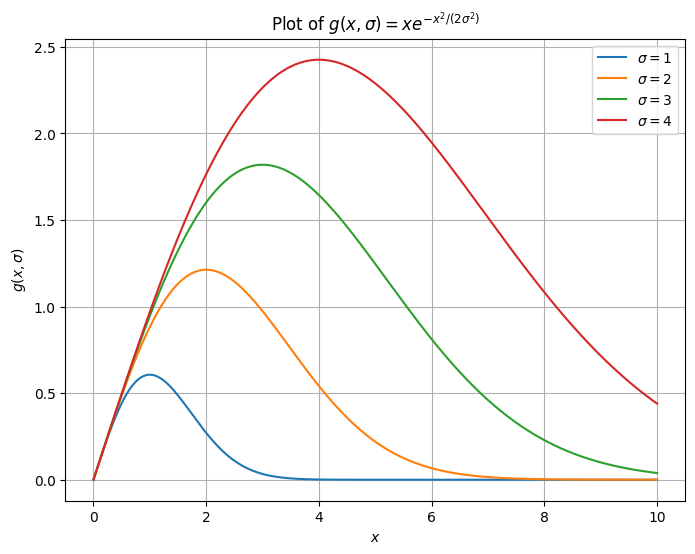

In [7]:
plt.figure(figsize=(8, 6))
for sigma in sigmas[:4]:
    plt.plot(x, g(x, sigma), label=rf"$\sigma = {sigma}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$g(x, \sigma)$")
plt.title(r"Plot of $g(x, \sigma) = x e^{-x^2 / (2\sigma^2)}$")
plt.legend()
plt.grid()
plt.show()

We can see how the function $g(x)$ has a similar shape to the function $f(x)$, so we expect that the results will be better than the classical Monte Carlo integration in terms of speed of convergence and accuracy.

### Plot the results
#### Residue vs sigma

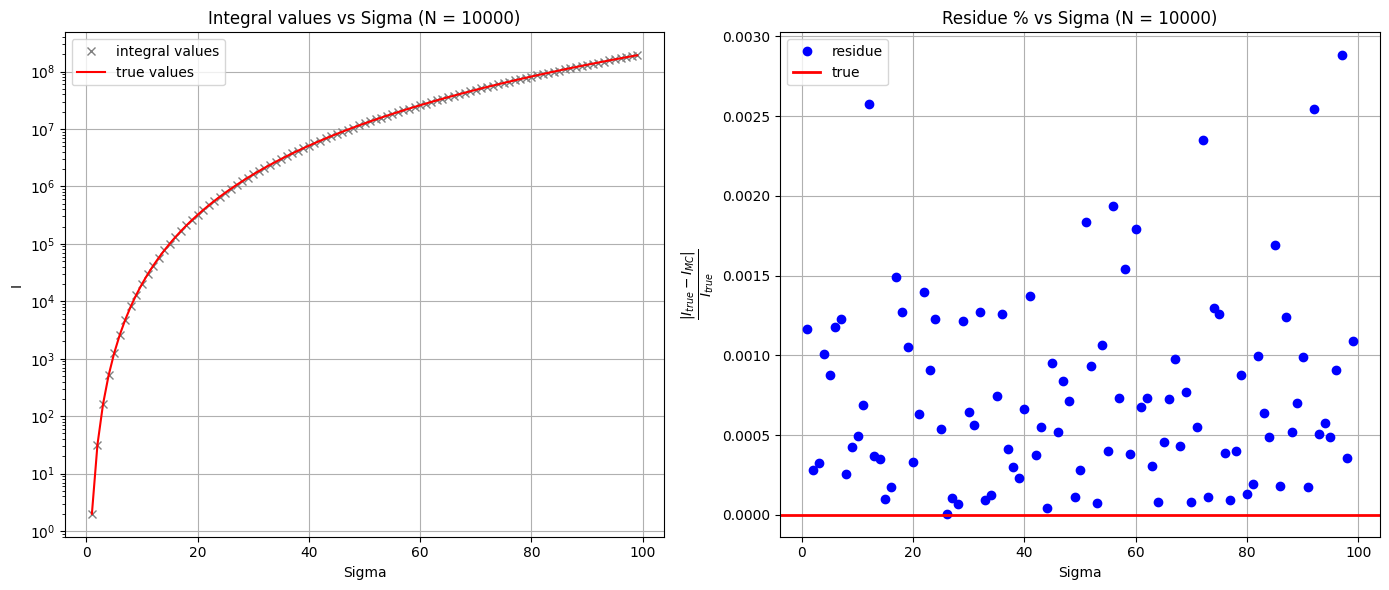

In [8]:
integral_values = []
true_values = []
residue = []
for sigma in sigmas:
    G_lambda = lambda x: G(x, sigma)
    inverse_G_lambda = lambda x: inverse_G(x, sigma)
    integral_value = 0
    for _ in range(l):
        integral_value += MonteCarlo_importance_sampling(G_lambda, inverse_G_lambda, 0, np.inf)
    integral_value /= l

    true_value = 2 * sigma ** 4
    integral_values.append(integral_value)
    true_values.append(true_value)
    residue.append(np.abs(true_value - integral_value)/true_value)

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(sigmas, integral_values, "x", label="integral values", color="gray")
axs[0].plot(sigmas, true_values, label="true values", color="red")
axs[0].set_xlabel("Sigma")
axs[0].set_ylabel("I")
axs[0].set_title("Integral values vs Sigma (N = 10000)")
axs[0].set_yscale("log")
axs[0].legend()
axs[0].grid()

axs[1].plot(sigmas, residue, "o", label="residue", color="blue")
axs[1].axhline(0, color='red', linewidth=2, label='true')
axs[1].set_xlabel("Sigma")
axs[1].set_ylabel(r"$\frac{|I_{true} - I_{MC}|}{I_{true}}$", size=14)
axs[1].set_title("Residue % vs Sigma (N = 10000)")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

We can observe better results compared with the onces obtained with the first approch, even if they are comparable.

#### Residue vs N

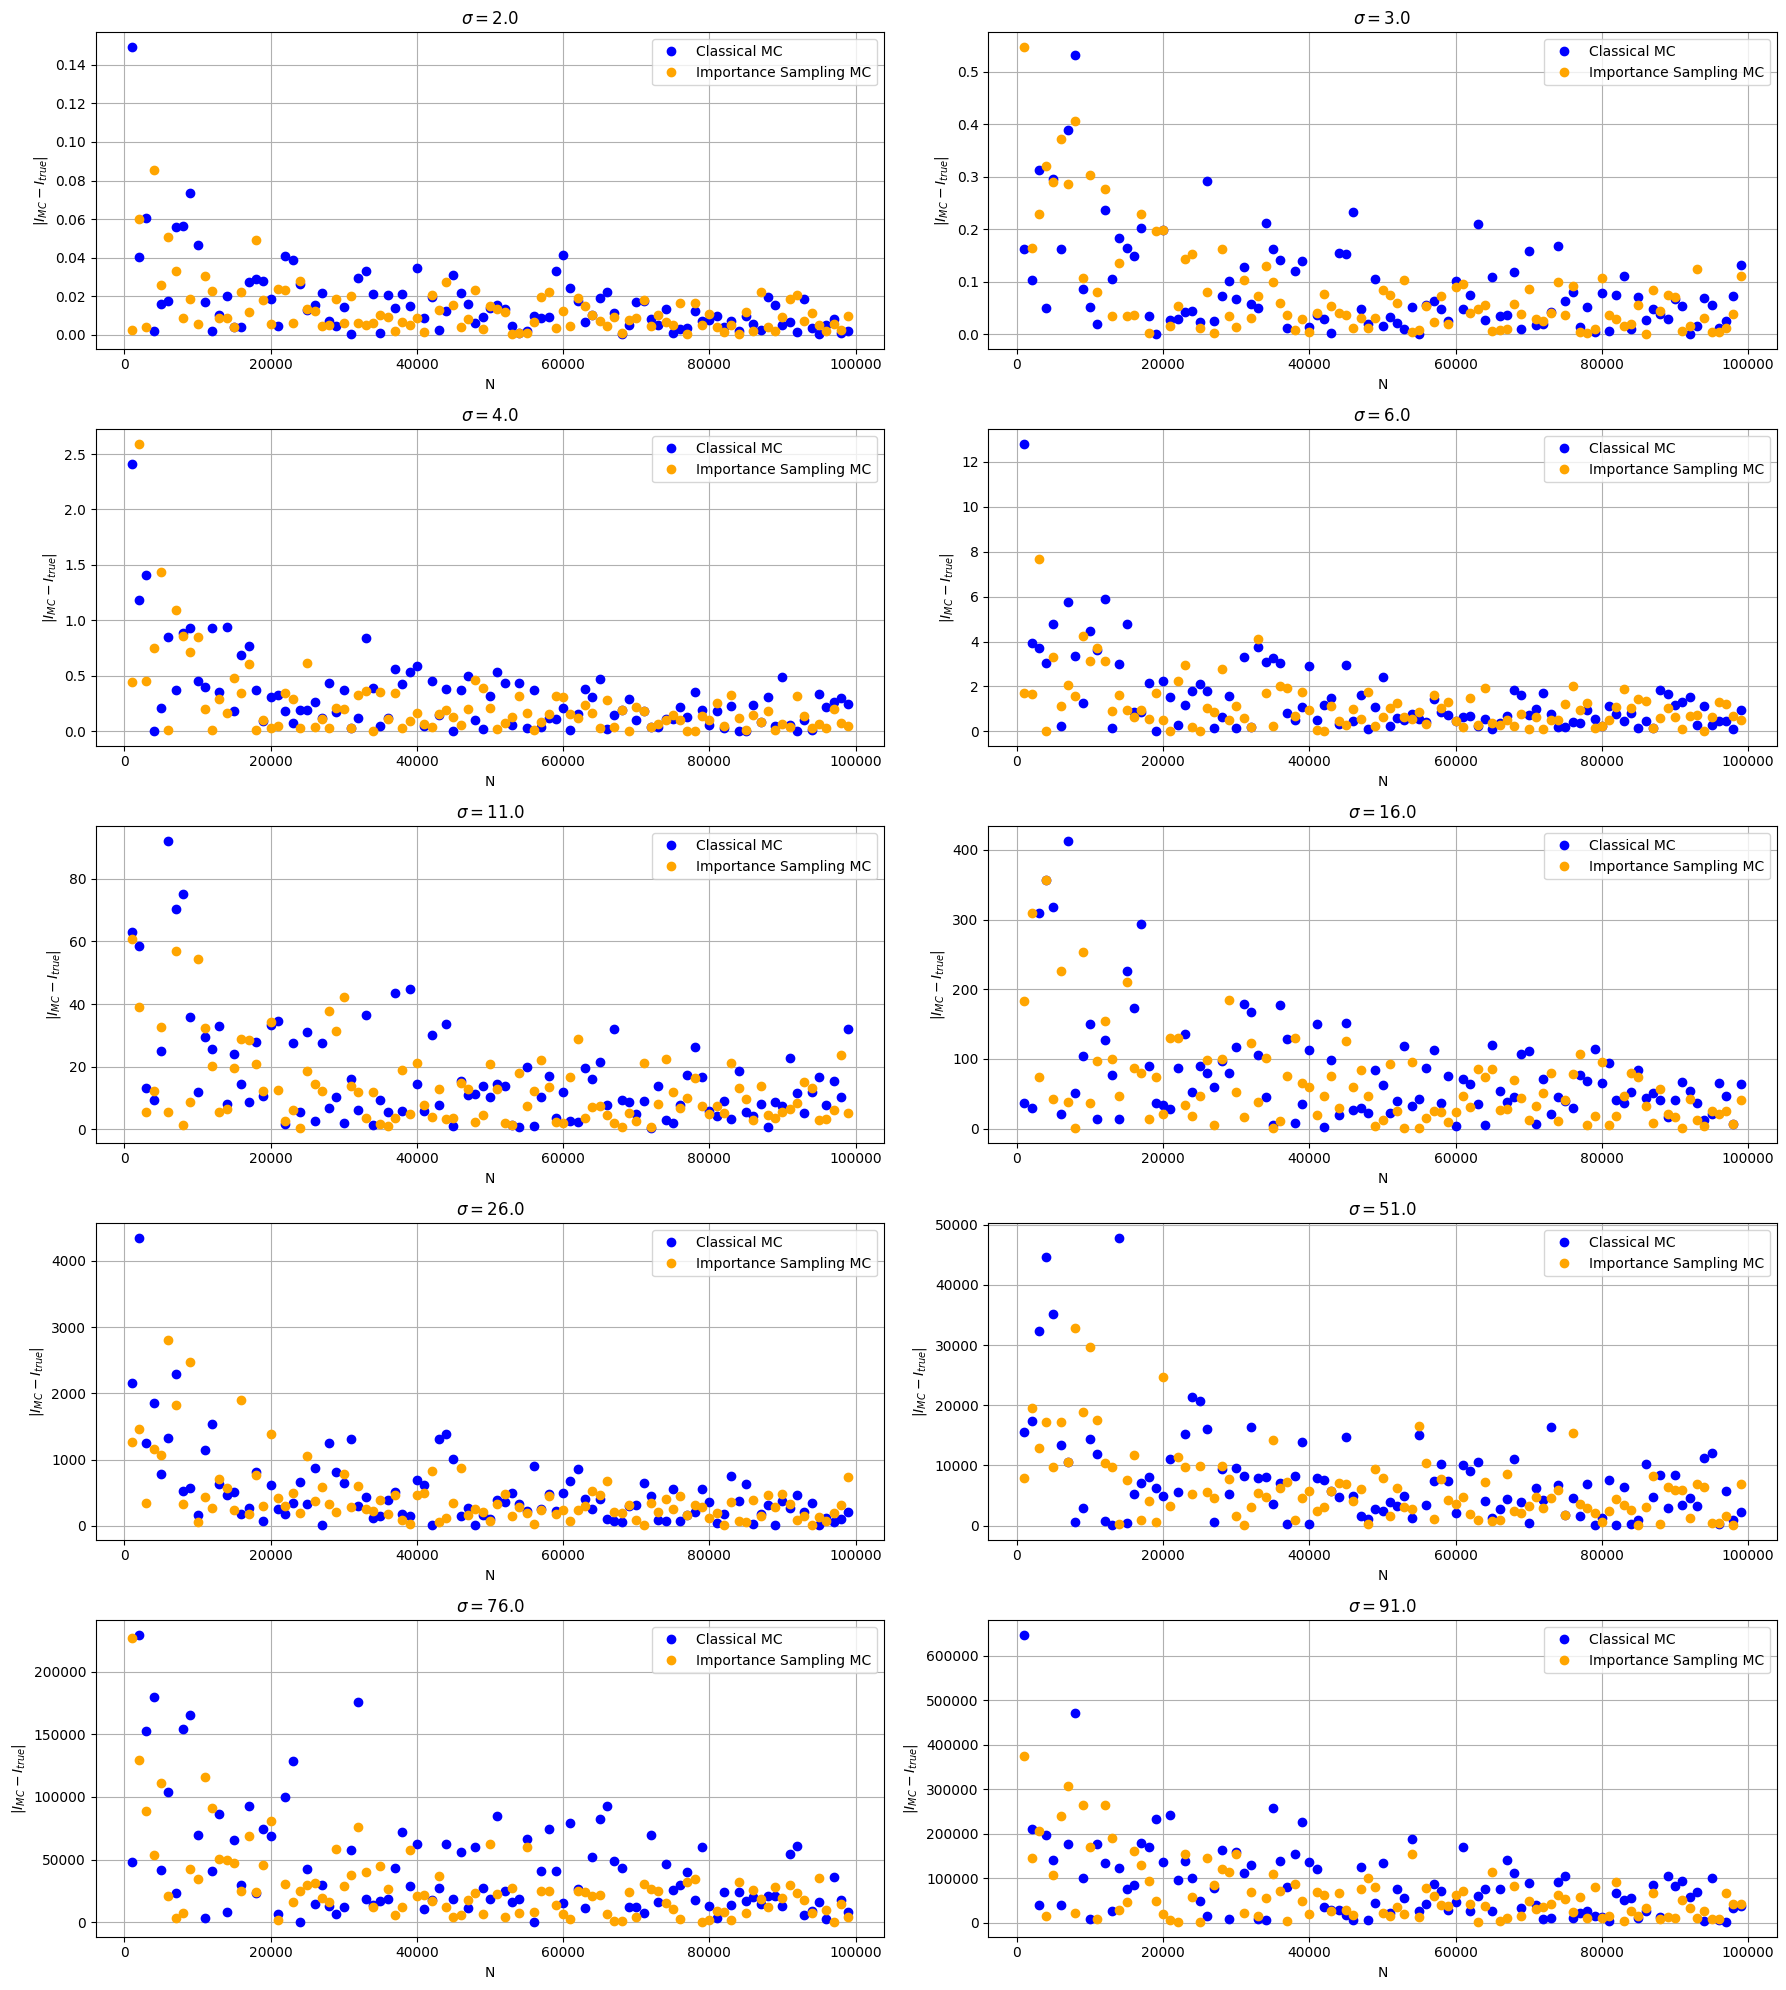

In [9]:
N_values = []
sigmas_index = [1, 2, 3, 5, 10, 15, 25, 50, 75, 90]
MC_integrals = [[] for _ in range(len(sigmas))]
ISMC_integrals = [[] for _ in range(len(sigmas))]

for n in range(1000, 100000, 1000):
    N_values.append(n)
    for j,i in enumerate(sigmas_index):
        true_val = 2 * sigmas[i] ** 4

        # Classical MC
        f_lambda = lambda x: f(x, sigmas[i])
        mc_val = 0
        for _ in range(l):
            mc_val += MonteCarlo_integration(f_lambda, 0, extremes[i], N=n)
        mc_val /= l
        MC_integrals[j].append(np.abs(mc_val - true_val))
        
        # Importance Sampling MC
        G_lambda = lambda x: G(x, sigmas[i])
        inverse_G_lambda = lambda x: inverse_G(x, sigmas[i])
        ismc_val = 0
        for _ in range(l):
            ismc_val += MonteCarlo_importance_sampling(G_lambda, inverse_G_lambda, 0, np.inf, N=n)
        ismc_val /= l
        ISMC_integrals[j].append(np.abs(ismc_val - true_val))

fig, axs = plt.subplots(5, 2, figsize=(18, 20))
axs = axs.flatten()

for j,i in enumerate(sigmas_index):
    axs[j].plot(N_values, MC_integrals[j], 'o', label="Classical MC", color="blue")
    axs[j].plot(N_values, ISMC_integrals[j], 'o', label="Importance Sampling MC", color="orange")
    # axs[j].set_yscale("log")
    axs[j].set_title(rf"$\sigma = {sigmas[i]:.1f}$")
    axs[j].set_xlabel("N")
    axs[j].set_ylabel(r'$|I_{MC} - I_{true}|$')
    axs[j].legend()
    axs[j].grid()

plt.tight_layout()
plt.show()

We can see again how the results of the two methods are comparable, but the Importance Sampling method is still better because we don't have to approximate the domain of integration.

#### Distribution of integral values

Integration simulation: 10it [30:37, 183.78s/it]


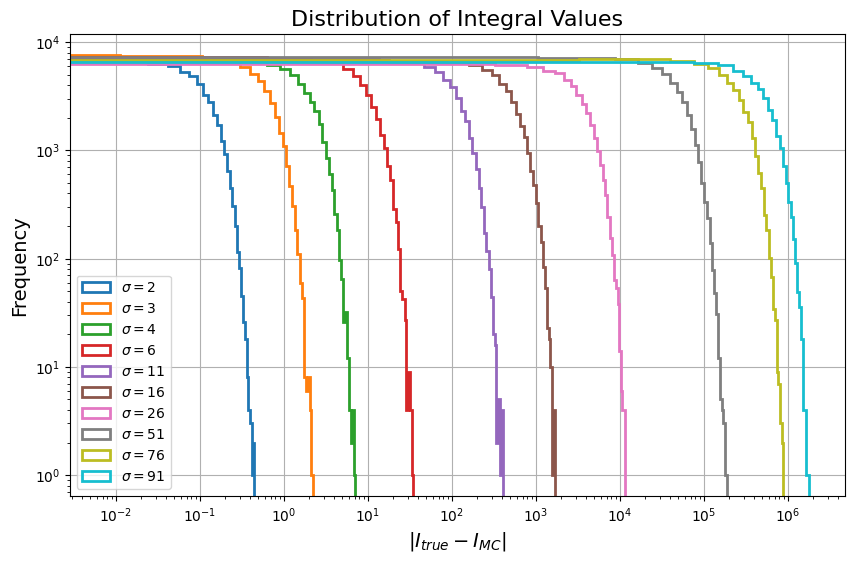

In [10]:
from tqdm import tqdm

integral_pdf = [[] for i in range(len(sigmas_index))]

for j,i in tqdm(enumerate(sigmas_index), desc="Integration simulation"):     
    G_lambda = lambda x: G(x, sigmas[i])
    inverse_G_lambda = lambda x: inverse_G(x, sigmas[i])
    for _ in range(100000):
        integral_value = MonteCarlo_importance_sampling(G_lambda, inverse_G_lambda, 0, np.inf, n) - (2 * sigmas[i] ** 4)
        integral_pdf[j].append(integral_value)

plt.figure(figsize=(10, 6))
for j,i in enumerate(sigmas_index):
    plt.hist(integral_pdf[j], bins=50, histtype="step", linewidth=2, label=rf"$\sigma = {sigmas[i]}$")
plt.xlabel(r"$|I_{true} - I_{MC}|$", size=14)
plt.ylabel("Frequency", size=14)
plt.yscale("log")
plt.xscale("log")
plt.title("Distribution of Integral Values", size=16)
plt.legend()
plt.grid()
plt.show()

Integration simulation: 0it [00:00, ?it/s]

Integration simulation: 10it [42:56, 257.69s/it]


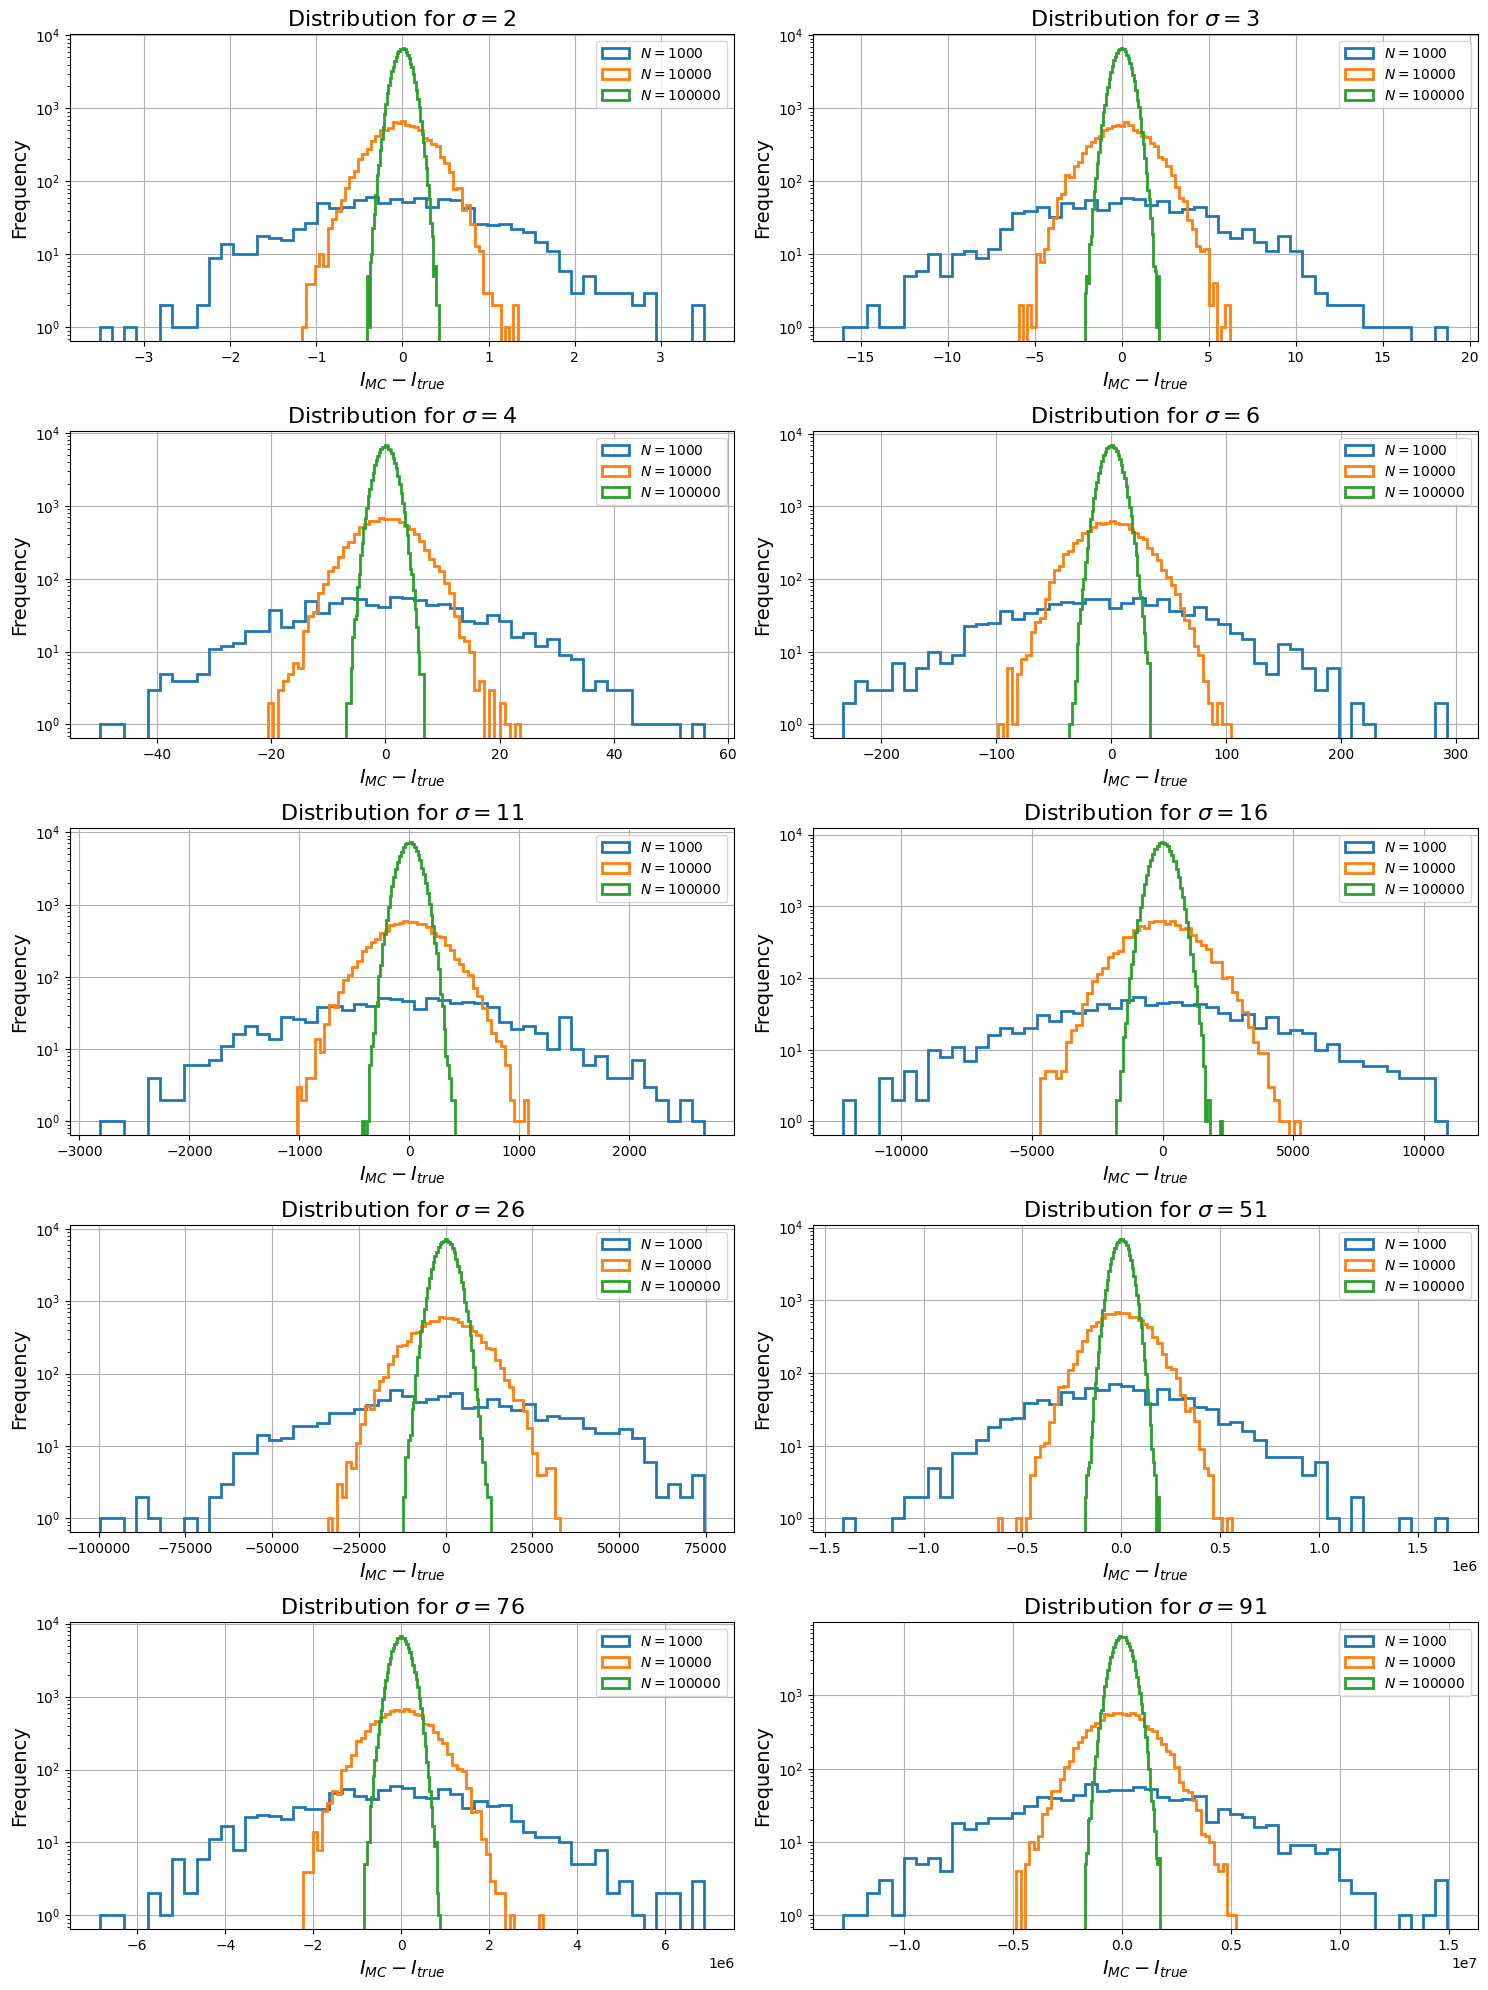

In [12]:
integral_pdf = [[[] for _ in range(3)] for _ in range(len(sigmas_index))]
N_values = [1000, 10000, 100000]

for k, i in tqdm(enumerate(sigmas_index), desc="Integration simulation"):
    G_lambda = lambda x: G(x, sigmas[i])
    inverse_G_lambda = lambda x: inverse_G(x, sigmas[i])
    for j, N in enumerate(N_values):
        for _ in range(N):
            integral_value = MonteCarlo_importance_sampling(G_lambda, inverse_G_lambda, 0, np.inf, N) - (2 * sigmas[i] ** 4)
            integral_pdf[k][j].append(integral_value)

fig, axs = plt.subplots(5, 2, figsize=(15, 20))
axs = axs.flatten()

for k, i in enumerate(sigmas_index):
    for j, N in enumerate(N_values):
        axs[k].hist(integral_pdf[k][j], bins=50, histtype="step", linewidth=2, label=rf"$N = {N}$")
    axs[k].set_yscale("log")
    axs[k].set_xlabel(r"$I_{MC} - I_{true}$", size=14)
    axs[k].set_ylabel("Frequency", size=14)
    axs[k].set_title(rf"Distribution for $\sigma = {sigmas[i]}$", size=16)
    axs[k].legend()
    axs[k].grid()

plt.tight_layout()
plt.show()

## Monte Carlo - Gaussian sampling

A third possible approach is to use a different pdf for sample the data, infect at the basis of the Monte Carlo approach there is the following idea:
$$
\int\,dx\,f(x)p(x) = \frac{1}{N}\sum_{i=1}^Nf(x_i)\hspace{1cm}\int\,dx\, p(x) = 1
$$
so it isn't necessary that $p(x)$ is the uniform distribution. 

In the case of interest the integral of $e^{-\frac{x^2}{2\sigma^2}}$ is a finite scalar number, and with the correct normalization we can solve the integral using random numbers normal distributed.

$$
\int_0^\infty \, dx\, x^3 e^{-\frac{x^2}{2\sigma^2}} =\frac{\sqrt{\pi}}{2} \int_0^\infty \, dx\, x^3\frac{2}{\sqrt{\pi}} e^{-\frac{x^2}{2\sigma^2}} = \frac{\sqrt{\pi}}{2}\frac{1}{N}\sum_{i=1}^N x_i^3
$$

where $x_i$ are random numbers sampled from a Gaussian distribution with mean 0 and standard deviation $\sigma$.